In [1]:
import random 
import numpy as np 
import torch 
from utilities.pg_utils import set_seed
set_seed(111)


In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


from typing import List
import torch 
from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
N_EPISODES = 150  # number of episodes to train the agent
N_ITERATIONS_PER_EPISODE = 20
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date)
# kraken_ds = KrakenDataSet(portfolio, WINDOW_SIZE)
agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
agent.pre_train()
# train the agent


pre-training ddpg agent started...
ReplayMemoryBuffer populating with experience...


KeyboardInterrupt: 

In [3]:
def calculate_total_return(equity_curve):
    """
    Calculate the total return from an equity curve.

    Args:
        equity_curve (list): List of portfolio values over time.

    Returns:
        float: Total return as a percentage.
    """
    V_start = equity_curve[0]
    V_end = equity_curve[-1]
    total_return = ((V_end - V_start) / V_start) * 100
    return total_return

In [4]:
calculate_total_return()

TypeError: calculate_total_return() missing 1 required positional argument: 'equity_curve'

In [5]:

import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)


Training Started for DDPG Agent
Episode 1 - Actor Loss: 0.0681, Critic Loss: 0.6449, Total Reward: 5.0958
Episode 2 - Actor Loss: 0.0640, Critic Loss: 0.6558, Total Reward: 5.8257
Episode 3 - Actor Loss: 0.0584, Critic Loss: 0.6659, Total Reward: 5.2476
Episode 4 - Actor Loss: 0.0590, Critic Loss: 0.6728, Total Reward: 4.7780
Episode 5 - Actor Loss: 0.0585, Critic Loss: 0.6886, Total Reward: 4.8731
Episode 6 - Actor Loss: 0.0603, Critic Loss: 0.7144, Total Reward: 4.7458
Episode 7 - Actor Loss: 0.0598, Critic Loss: 0.7266, Total Reward: 3.8048
Episode 8 - Actor Loss: 0.0573, Critic Loss: 0.7313, Total Reward: 4.3732
Episode 9 - Actor Loss: 0.0556, Critic Loss: 0.7332, Total Reward: 3.7559
Episode 10 - Actor Loss: 0.0556, Critic Loss: 0.7476, Total Reward: 4.7544
Episode 11 - Actor Loss: 0.0551, Critic Loss: 0.7612, Total Reward: 5.0921
Episode 12 - Actor Loss: 0.0592, Critic Loss: 0.7577, Total Reward: 3.8470
Episode 13 - Actor Loss: 0.0614, Critic Loss: 0.7746, Total Reward: 5.0664
Ep

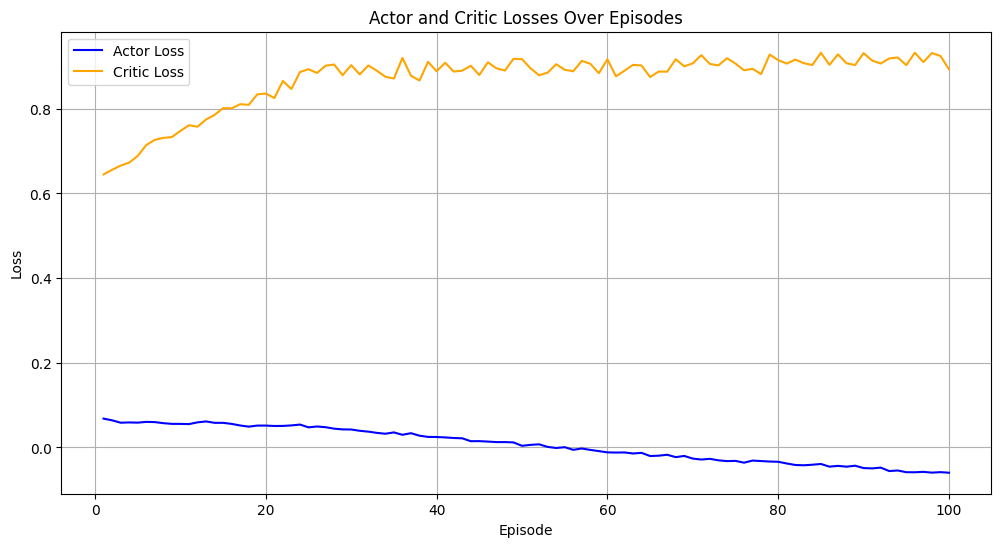

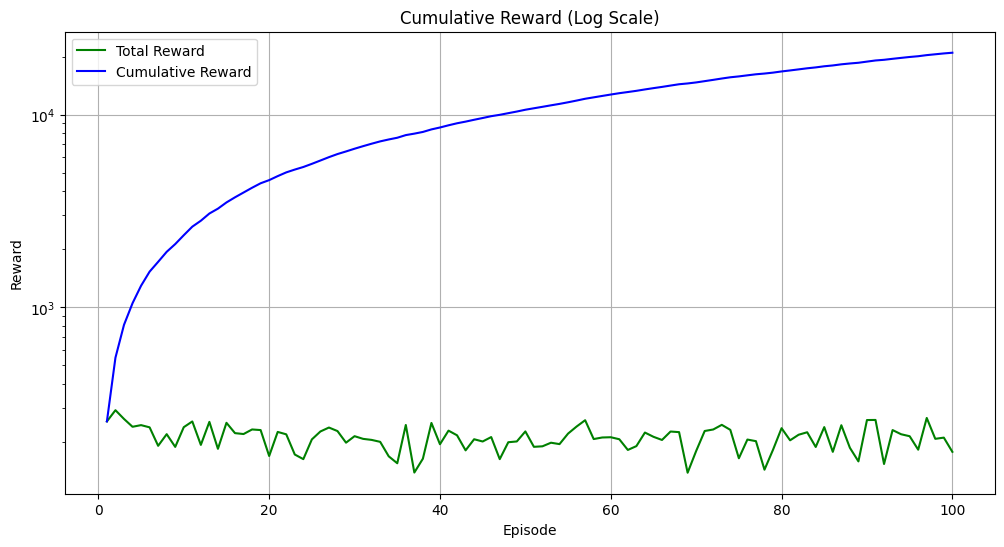

In [6]:
# train agent
agent.train(100);

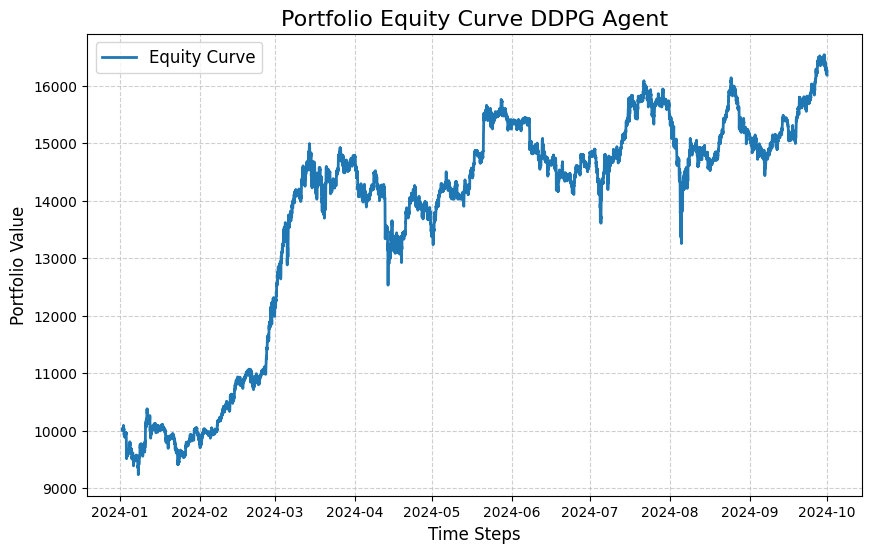

In [7]:
# checking pvm as it should be similar to buy and hold prior to training
import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)
cl_price = portfolio.get_close_price()
dates = cl_price.index


pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []

for i in range(len(ds) + 48):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    wt_cash = 1 - wt.sum()
    wt = torch.concat([wt_cash.unsqueeze(0), wt], dim=-1)
    weights.append(wt)
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current

# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], agent_equity_curve, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve DDPG Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [8]:
calculate_total_return(agent_equity_curve)

62.529746093750006

In [8]:
calculate_total_return(agent_equity_curve)

61.858896484375

In [ ]:
weights[-5:]

In [ ]:
# buy and hold
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 48):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve Buy And Hold", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [ ]:
calculate_total_return(buy_and_hold_equity)

In [ ]:
calculate_total_return(agent_equity_curve)

In [ ]:
rewards = [exp.reward for exp in agent.replay_memory.buffer]

In [ ]:
import matplotlib.pyplot as plt
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")

plt.grid()

In [ ]:
np.random.uniform(
                -3, 3
            )  # Simulate expected reward range